In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [6]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner
import smthphoto as sph

ImportError: No module named smthphoto

In [5]:
from __future__ import unicode_literals

figsize(16, 10)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [42]:
freqs = []
fluxs = []
errors = []
for k, pf in enumerate(sph.planckfiles):
    nu = sph.planckfreqs[k]
    pflux, perr = sph.planck_calc(pf, nu, inside=80, outside=100)
    freqs.append(nu)
    fluxs.append(pflux)
    errors.append(perr)
for k, pf in enumerate(sph.wmapfiles):
    nu = sph.wmapfreqs[k]
    pflux, perr = sph.wmap_calc(pf, nu, inside=80, outside=100)
    freqs.append(nu)
    fluxs.append(pflux)
    errors.append(perr)
for k, pf in enumerate(sph.dirbefiles):
    nu = sph.dirbefreqs[k]
    pflux, perr = sph.dirbe_flux(pf, inside=80, outside=100)
    freqs.append(nu)
    fluxs.append(pflux)
    errors.append(perr)
for k, pf in enumerate(sph.irisfiles):
    nu = sph.irisfreqs[k]
    pflux, perr = sph.iris_flux(pf, inside=80, outside=100)
    freqs.append(nu)
    fluxs.append(pflux)
    errors.append(perr)


freqs.append(408.e6)
fluxs.append(26.8)
errors.append(5.)
freqs.append(1.420e9)
fluxs.append(23.4)
errors.append(4.)
freqs = np.array(freqs)
fluxs = np.array(fluxs)
errors = np.array(errors)

In [43]:
mask = freqs < 3.1e12

In [44]:
freqs = freqs[mask]
fluxs = fluxs[mask]
errors = errors[mask]

In [45]:
nu = np.logspace(8, 13, 2000)

In [46]:
beam = pi*(1.*pi/180.)**2
beam2 = pi*((0.16/60.)*pi/180.)**2

In [47]:
nfreqs = np.array([4.575, 5.625, 6.125]) * 1.e9
newdata = np.array([ 17.05, 17.66, 19.5])
nerrs = newdata * 0.1

In [48]:
bigfs = np.concatenate([freqs, nfreqs])
bigdata = np.concatenate([fluxs, newdata])
bigerrs = np.concatenate([errors, nerrs])

In [49]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [50]:
def signal2(freqs, EM1, EM2, abeam, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [51]:
pn = np.array([100., 1.e-3, 20.e9, 1.e-4, 2., 20., 30.e-6])
x = curve_fit(signal, bigfs, bigdata, p0=pn, sigma=bigerrs, absolute_sigma=True)
pfit3 = x[0]

In [52]:
pn2 = np.array([100., 1.e6, beam2, 1.e-4, 2., 20., 30e-6])
y = curve_fit(signal2, bigfs, bigdata, p0=pn2, sigma=bigerrs, absolute_sigma=True)
pfit4 = y[0]

(10, 100000.0)

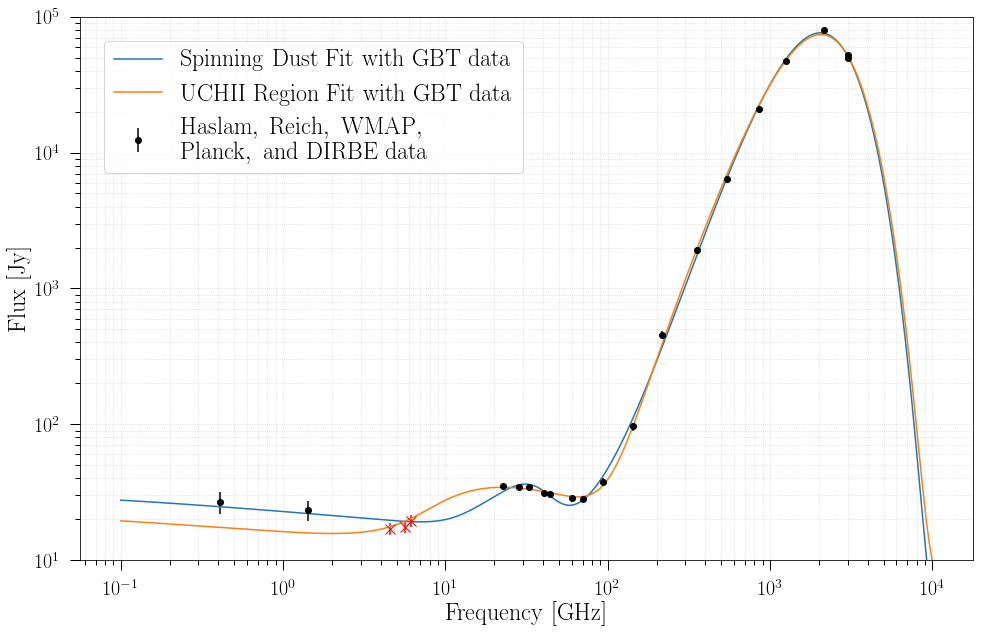

In [53]:
plot(nu*1.e-9, signal(nu, *pfit3), label='$\mathrm{Spinning\ Dust\ Fit\ with\ GBT\ data}$')
plot(nu*1.e-9, signal2(nu, *pfit4), label='$\mathrm{UCHII\ Region\ Fit\ with\ GBT\ data}$')
errorbar(freqs*1.e-9, fluxs, yerr=errors, fmt='ko',\
         label='$\mathrm{Haslam,\ Reich,\ WMAP,}$\n$\mathrm{Planck,\ and\ DIRBE\ data}$')
errorbar(nfreqs*1e-9, newdata, yerr=nerrs, fmt='rx', markersize=10)

xscale('log')
yscale('log')
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
legend(loc=2, ncol=1)
grid(ls='dotted', alpha=0.5)
grid(which='minor', ls='dotted', alpha=0.5)
ylim(10, 1e5)
#savefig('../notebooks/fullspectrum_with_gbt.pdf', format='pdf')

In [45]:
ff2a = fg.freefreep(freqs, EM=pfit2[1]) * pfit2[2]
ff2 = fg.freefreep(freqs, EM=pfit4[1]) * pfit4[2]

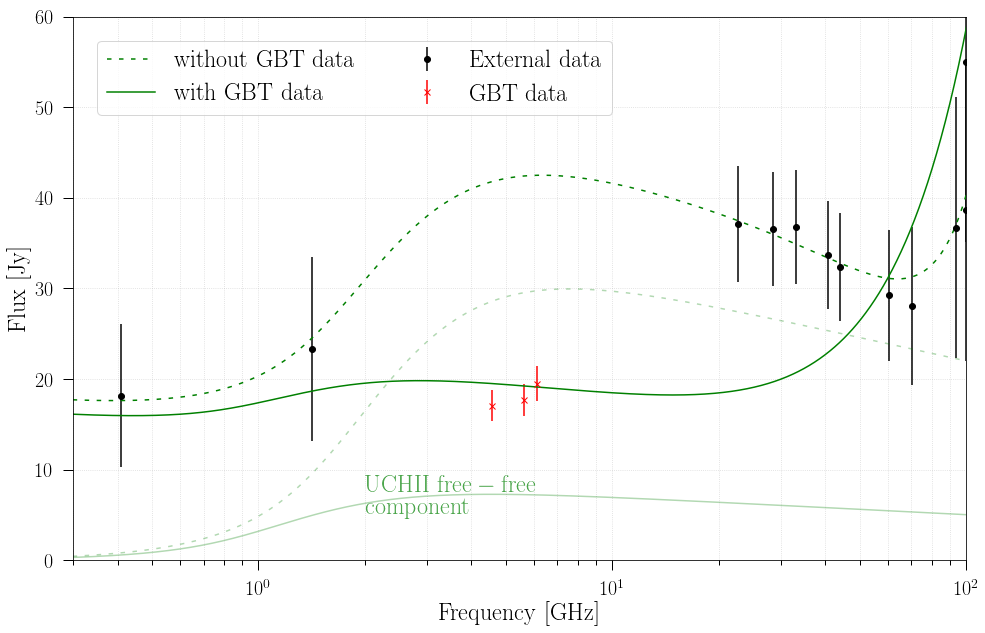

In [58]:
plot(nu, signal2(freqs, *pfit2), 'green', ls='dashed', dashes=(3,5), label='$\mathrm{without\ GBT\ data}$')
plot(nu, signal2(freqs, *pfit4), 'green', label='$\mathrm{with\ GBT\ data}$')
errorbar(cfs*1.e-9, cjys, yerr=cerrs, fmt='ko', label='$\mathrm{External\ data}$')
errorbar(nfreqs*1.e-9, newdata, yerr=nerrs, fmt='rx', label='$\mathrm{GBT\ data}$')

alpha = 0.3
plot(nu, ff2, 'green', alpha=alpha)
plot(nu, ff2a, 'green', alpha=alpha, ls='dashed', dashes=(3,5))

xscale('log')
ylim(0, 60)
xlim(0.3, 100)
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
legend(loc=2, ncol=2)
grid(ls='dotted', alpha=0.5)
grid(which='minor', ls='dotted', alpha=0.5)
text(2, 5, '$\mathrm{UCHII\ free-free}$\n $\mathrm{component}$', fontsize=24, color='green', alpha=0.7);
savefig('../notebooks/freefreefit.pdf', format='pdf')

In [59]:
ame0a = fg.ame(freqs, pfit1[1], pfit1[2]) * beam
ame0 = fg.ame(freqs, pfit3[1], pfit3[2]) * beam

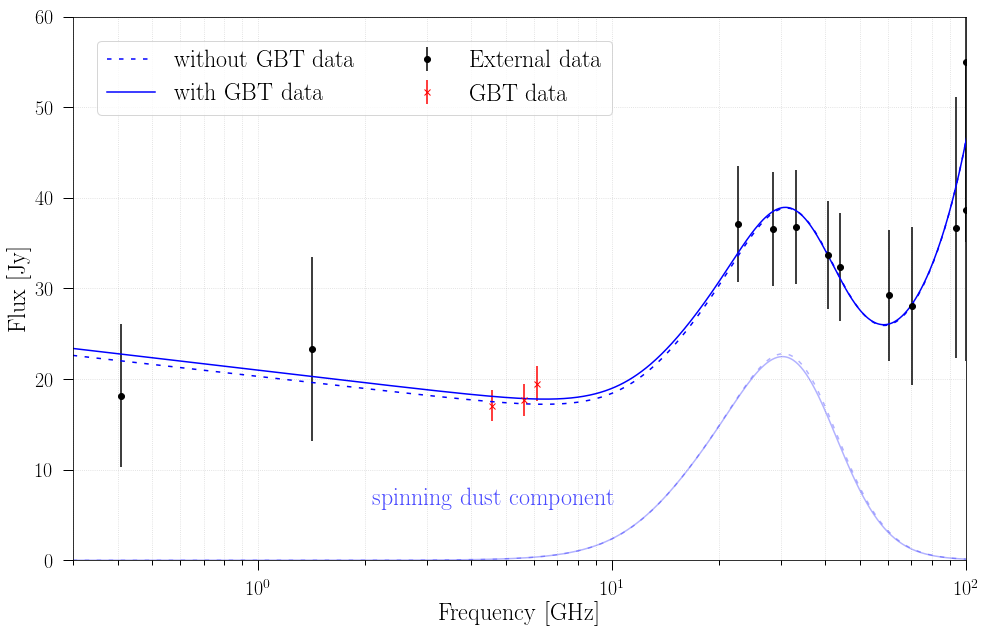

In [61]:
plot(nu, signal(freqs, *pfit1), 'blue', ls='dashed', dashes=(3,5), label='$\mathrm{without\ GBT\ data}$')
plot(nu, signal(freqs, *pfit3), 'blue', label='$\mathrm{with\ GBT\ data}$')
errorbar(cfs*1.e-9, cjys, yerr=cerrs, fmt='ko', label='$\mathrm{External\ data}$')
errorbar(nfreqs*1.e-9, newdata, yerr=nerrs, fmt='rx', label='$\mathrm{GBT\ data}$')

alpha = 0.3
plot(nu, ame0, 'blue', alpha=alpha)
plot(nu, ame0a, 'blue', alpha=alpha, ls='dashed', dashes=(3,5))

xscale('log')
ylim(0, 60)
xlim(0.3, 100)
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
legend(loc=2, ncol=2)
grid(ls='dotted', alpha=0.5)
grid(which='minor', ls='dotted', alpha=0.5)
text(2.1, 6, '$\mathrm{spinning\ dust\ component}$', fontsize=24, color='blue', alpha=0.7);
savefig('../notebooks/spinningdustfit.pdf', format='pdf')